In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle

from mpi4py import MPI

# 1. Investigate Target Signal

In [2]:
def apply_changes(yy, changes):
    yy = yy.copy()

    for change in changes:
        yy += change

    return yy

In [3]:
def plot_signal_changes(tt, yy, changes):
    fig, ax = plt.subplots(len(changes), 2, figsize=(12, 3 * len(changes)), sharex=True, sharey=True, frameon=False)

    yy = yy.copy()
    for i in range(len(changes)):
        for j in range(2):
            if j % 2:
                yy += changes[i]
                ax[i, j].plot(tt / (2 * np.pi), yy)
                ax[i, j].grid()
            else:
                ax[i, j].plot(tt / (2 * np.pi), changes[i])
                ax[i, j].grid()

    fig.text(0.5, 0.0, '$t$, cycles', ha='center', va='top', fontsize=14)
    fig.text(0.0, 0.5, 'Signal, arb.units', ha='right', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.show()

In [4]:
tt = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 3 ** 9)

changes = [np.zeros_like(tt), 
           np.sin(3 * tt) * np.exp(-(tt - 5 * 2 * np.pi) ** 2 / (2 * 20 ** 2)), 
           np.sin(5.5 * tt) * np.exp(-(tt + 10 * 2 * np.pi) ** 2 / (2 * 5 ** 2)),
           np.sin(4 * tt) * np.exp(-(tt - 7 * 2 * np.pi) ** 2 / (2 * 10 ** 2))]

yy = np.sin(tt) * np.exp(-tt ** 2 / (2 * 20 ** 2))

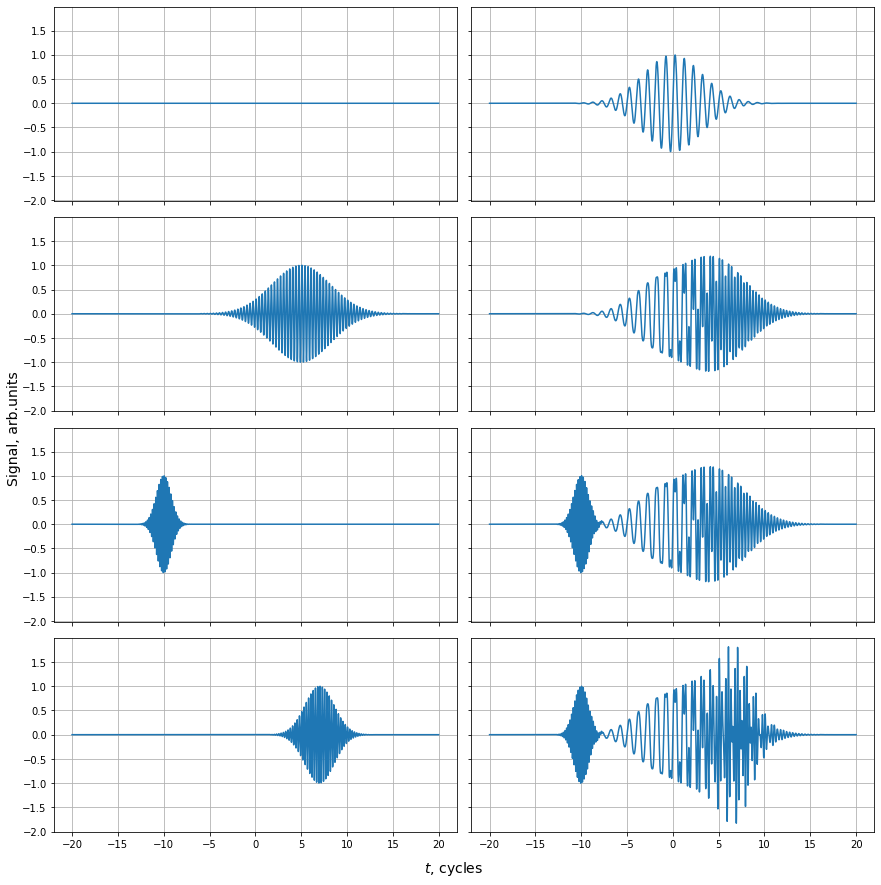

In [5]:
plot_signal_changes(tt, yy, changes)

In [6]:
yy_changed = apply_changes(yy, changes)

In [7]:
def plot_signal_frequencies(tt, yy):
    values = np.abs(np.fft.fft(yy)[:len(yy) // 2]) ** 2
    frequencies = np.fft.fftfreq(len(yy), d=(tt[1] - tt[0]) / (2 * np.pi))[:len(yy) // 2]

    plt.figure(figsize=(10, 8))
    plt.plot(frequencies, values)

    plt.xlim(0., 6.)
    plt.xlabel('Frequency, arb. units', fontsize=14)
    plt.ylabel('Power spectrum, arb. units', fontsize=14)

    plt.grid()
    plt.show()

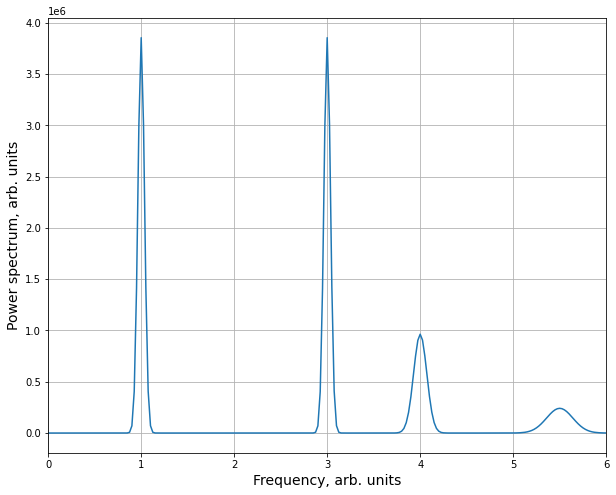

In [8]:
plot_signal_frequencies(tt, yy_changed)

In [9]:
with open(f'tt.pkl', 'wb') as f:
    pickle.dump(tt, f)

with open(f'yy.pkl', 'wb') as f:
    pickle.dump(yy_changed, f)

# 2. Implement Parallel Gabor Transform using `mpi4py`

In [10]:
%%writefile solution-lab-6.py

import numpy as np
import pickle
import sys

from mpi4py import MPI

### define functions for transformation

def construct_spectrogram(tt, yy, window_positions_range, window_width=4.0 * 2 * np.pi):
    tt_size = len(tt) // 2
    spectrogram = np.zeros((len(window_positions_range), tt_size), dtype=np.float32)

    for i, window_position in enumerate(window_positions_range):
        window_function = np.exp(-(tt - window_position) ** 2 / (2 * window_width**2))
        yy_window = (yy * window_function)

        values = np.abs(np.fft.fft(yy_window)) ** 2
        spectrogram[i, :] = values[:tt_size]

    return np.log(1 + spectrogram).reshape(-1)

### setup mpi environment

comm = MPI.COMM_WORLD
start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### read parameters of signal

with open(f'tt.pkl', 'rb') as f:
    tt = pickle.load(f)

with open(f'yy.pkl', 'rb') as f:
    yy = pickle.load(f)

tt_size = len(tt) // 2

### define parameters for transformation

n_window_steps = 1000 if len(sys.argv) < 2 else int(sys.argv[1])
window_width = 4.0 * 2 * np.pi if len(sys.argv) < 3 else int(sys.argv[2])

window_positions = np.linspace(-30 * 2 * np.pi, 30 * 2 * np.pi, n_window_steps, dtype=np.float32)
frequencies = np.fft.fftfreq(len(yy), d=(tt[1] - tt[0]) / (2 * np.pi))[:tt_size]

### assign transformation parts between processes

window_positions_count = int(len(window_positions) / size)
window_positions_range = window_positions[rank * window_positions_count:(rank + 1) * window_positions_count]
spectrogram_complete = np.empty(tt_size * len(window_positions), dtype=np.float32) if rank == root else None

### perform transformation in every process

spectrogram_range = construct_spectrogram(tt.astype(np.float32), yy.astype(np.float32), window_positions_range, window_width)

### gather transformation results in root process

comm.Gather(spectrogram_range, spectrogram_complete, root)
end = MPI.Wtime()

if rank == root:
    with open(f'positions-{size}.pkl', 'wb') as f:
        pickle.dump(window_positions, f)
    
    with open(f'frequencies-{size}.pkl', 'wb') as f:
        pickle.dump(frequencies, f)

    with open(f'spectrogram-{size}.pkl', 'wb') as f:
        pickle.dump(spectrogram_complete.reshape(len(window_positions), tt_size).T, f)
    
    with open(f'time-{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Overwriting solution-lab-6.py


In [11]:
n_processes = 4
!mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-6.py {int(2e4)}

In [12]:
with open(f'positions-{n_processes}.pkl', 'rb') as f:
    window_positions = pickle.load(f)

with open(f'frequencies-{n_processes}.pkl', 'rb') as f:
    frequencies = pickle.load(f)
    
with open(f'spectrogram-{n_processes}.pkl', 'rb') as f:
    spectrogram_complete = pickle.load(f)

In [13]:
def plot_spectrogram(window_positions, frequencies, spectrogram):
    plt.figure(figsize=(12, 12))
    plt.imshow(spectrogram, interpolation='nearest', aspect='auto', cmap=cm.Blues_r,
            extent=[window_positions.min() / (2 * np.pi), window_positions.max() / (2 * np.pi), frequencies.max(), frequencies.min()])

    plt.ylim(0, 7)
    plt.xlabel('$t$, cycles', fontsize=14)
    plt.ylabel('Power spectrum, arb. units', fontsize=14)
    plt.show()

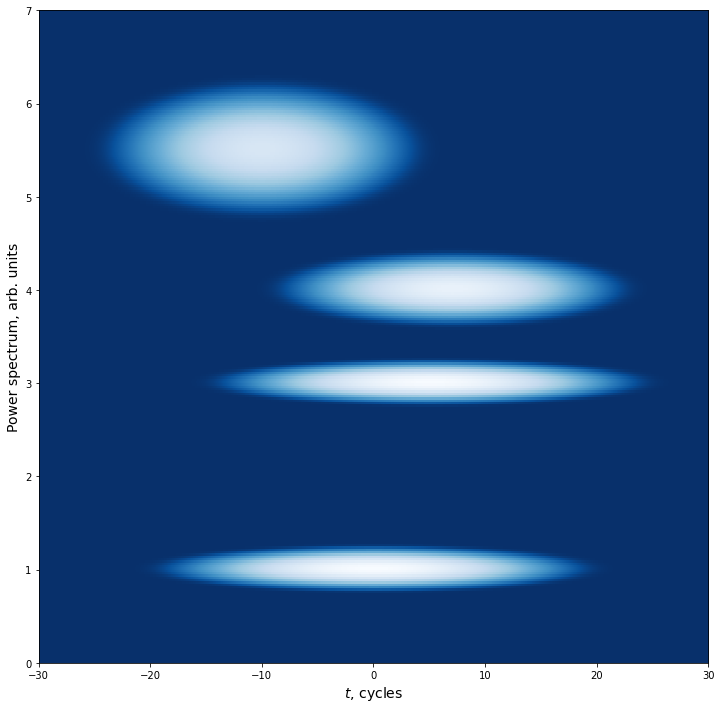

In [14]:
plot_spectrogram(window_positions, frequencies, spectrogram_complete)

# 3. Plot Speedup for Different Number of Processes

In [21]:
nn = np.logspace(0, 2, base=2, num=3).astype(np.int)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-6.py {int(2e4)}

In [22]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

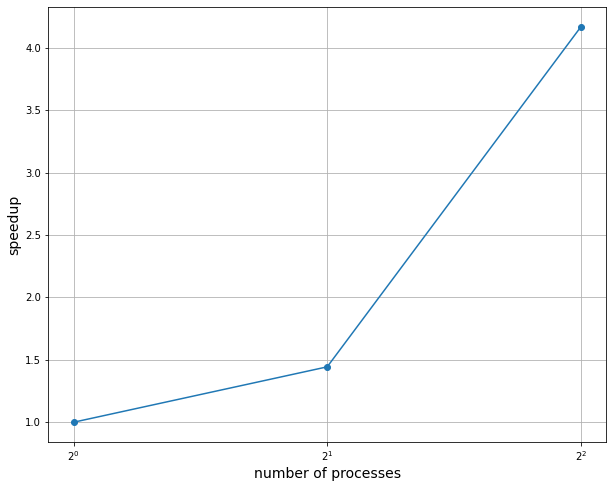

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()